In [131]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")

python-dotenv could not parse statement starting at line 6


In [132]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")  

In [133]:
"""import operator
from typing import List
from langgraph.graph.message import add_messages
from pydantic import BaseModel , Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate"""

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode


In [134]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

In [135]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("C:\\Users\\itsme\\OneDrive\\Documents\\Assigment\\AI_Doc\\sample_contract.txt")
docs = loader.load()

In [136]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [137]:
new_docs=text_splitter.split_documents(documents=docs)

In [138]:
new_docs


[Document(metadata={'source': 'C:\\Users\\itsme\\OneDrive\\Documents\\Assigment\\AI_Doc\\sample_contract.txt'}, page_content='Service Agreement\n\nThis Service Agreement ("Agreement") is made between AlphaTech Inc. ("Provider") and the Client.'),
 Document(metadata={'source': 'C:\\Users\\itsme\\OneDrive\\Documents\\Assigment\\AI_Doc\\sample_contract.txt'}, page_content='1. Scope of Work:\nProvider agrees to deliver software development and cloud support services as per the attached Statement of Work (SOW).'),
 Document(metadata={'source': 'C:\\Users\\itsme\\OneDrive\\Documents\\Assigment\\AI_Doc\\sample_contract.txt'}, page_content='2. Payment Terms:\nClient agrees to pay Provider a monthly retainer of $5,000. Late payments may incur a 2% fee.'),
 Document(metadata={'source': 'C:\\Users\\itsme\\OneDrive\\Documents\\Assigment\\AI_Doc\\sample_contract.txt'}, page_content='3. Confidentiality:\nBoth parties agree to maintain the confidentiality of proprietary information.\n\n4. Termination

In [139]:
doc_string=[doc.page_content for doc in new_docs]
doc_string

['Service Agreement\n\nThis Service Agreement ("Agreement") is made between AlphaTech Inc. ("Provider") and the Client.',
 '1. Scope of Work:\nProvider agrees to deliver software development and cloud support services as per the attached Statement of Work (SOW).',
 '2. Payment Terms:\nClient agrees to pay Provider a monthly retainer of $5,000. Late payments may incur a 2% fee.',
 '3. Confidentiality:\nBoth parties agree to maintain the confidentiality of proprietary information.\n\n4. Termination Clause:\nEither party may terminate this Agreement with 30 days written notice.',
 '5. Data Security:\nProvider shall implement appropriate technical and organizational measures to ensure data protection and comply with relevant data privacy laws, including GDPR.',
 "6. Limitation of Liability:\nProvider's liability shall not exceed the total fees paid by the Client in the last 6 months.",
 '7. Governing Law:\nThis Agreement shall be governed by the laws of the State of California.\n\nIN WITNE

In [140]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")  # or "text-embedding-3-large"
db = FAISS.from_documents(new_docs, embeddings)

In [141]:
db = FAISS.from_documents(new_docs, embeddings)

In [142]:
db

In [143]:
@tool
def search_doc(query: str) -> str:
    """
    Search the vector store for documents related to the input query.
    Returns the most relevant document chunks.
    """
    if not query:
        return "Please provide a valid query."

    results = db.similarity_search(query, k=1)  # top 3 relevant chunks
    return "\n\n".join([doc.page_content for doc in results])

In [144]:
tools=[search_doc]

In [145]:
llm_with_tool=llm.bind_tools(tools)

In [146]:
response=llm_with_tool.invoke("payment terms?")

In [147]:
response.tool_calls

[{'name': 'search_doc',
  'args': {'query': 'payment terms'},
  'id': 'call_xCMPUgWrGfjj8NmojCQSnRuK',
  'type': 'tool_call'}]

In [148]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [149]:
input={"messages":["payment terms?"]}
input

{'messages': ['payment terms?']}

In [150]:
response=call_model(input)

In [151]:
def router_function(state:MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END
    

In [152]:
tools


[StructuredTool(name='search_doc', description='Search the vector store for documents related to the input query.\nReturns the most relevant document chunks.', args_schema=<class 'langchain_core.utils.pydantic.search_doc'>, func=<function search_doc at 0x000002BCFD25D2D0>)]

In [153]:

tool_node=ToolNode(tools)

In [154]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search_doc': StructuredTool(name='search_doc', description='Search the vector store for documents related to the input query.\nReturns the most relevant document chunks.', args_schema=<class 'langchain_core.utils.pydantic.search_doc'>, func=<function search_doc at 0x000002BCFD25D2D0>)}, tool_to_state_args={'search_doc': {}}, tool_to_store_arg={'search_doc': None}, handle_tool_errors=True, messages_key='messages')

In [155]:
workflow=StateGraph(MessagesState)

In [156]:
workflow.add_node("llmwithtool",call_model)

workflow.add_node("docnode",tool_node)

workflow.add_edge(START,"llmwithtool")

workflow.add_conditional_edges("llmwithtool",
                                router_function,
                                {"tools":"docnode",
                                 END:END})

In [157]:
app=workflow.compile()

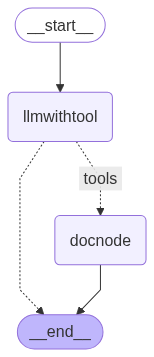

In [158]:
app

In [159]:
response=app.invoke({"messages":["hi"]})

In [160]:
response

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='1762044a-561b-4f1f-981d-ca24e00ef42f'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 57, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bmc20TgKvwO1JbCZ3eg8zPY07QRfq', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--cacd01e7-28cc-420b-9f8c-492edabf4b7d-0', usage_metadata={'input_tokens': 57, 'output_tokens': 10, 'total_tokens': 67, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [161]:
response1=app.invoke({"messages":["payment terms?"]})
response1

{'messages': [HumanMessage(content='payment terms?', additional_kwargs={}, response_metadata={}, id='6dee5c59-8e96-4a94-8849-698659057c51'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YjA0JFESjXtmr7i866ZUtNkP', 'function': {'arguments': '{"query":"payment terms"}', 'name': 'search_doc'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 59, 'total_tokens': 74, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bmc21ZNXyeWcqrwB27Zwn239J5pph', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--44fa331d-a906-47c5-bf26-377bb8714228-0', tool_calls=[{'name': 'search_doc', 'args': {'query': 'payment terms'}, 'id': 'call_YjA0

In [162]:
workflow.add_edge("docnode","llmwithtool")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [ ]:
app1=workflow.compile()
app1

In [165]:
for output in app.stream({"messages":["payment details?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")
    

here is output from llmwithtool
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RIqtDjDK2FyZR5XpHaX31qGF', 'function': {'arguments': '{"query":"payment details"}', 'name': 'search_doc'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 59, 'total_tokens': 74, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bmc3u4sQpMGg8G5kuYH6lz3B8keRa', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e6dc6d68-37e3-4c40-a627-36e8e48e4d60-0', tool_calls=[{'name': 'search_doc', 'args': {'query': 'payment details'}, 'id': 'call_RIqtDjDK2FyZR5XpHaX31qGF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'ou

In [166]:
for output in app1.stream({"messages":["payment details?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")
    

here is output from llmwithtool
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fZZ9B4sezUKsgVoI9cAaXx2L', 'function': {'arguments': '{"query":"payment details"}', 'name': 'search_doc'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 59, 'total_tokens': 74, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bmc4XFtopWPnBmRfinWUIOqZO5xO3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b9c9c0b4-e24e-4238-9107-e9fe4c4a7a47-0', tool_calls=[{'name': 'search_doc', 'args': {'query': 'payment details'}, 'id': 'call_fZZ9B4sezUKsgVoI9cAaXx2L', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'ou